# Amazon SageMaker Model Monitor
This notebook shows how to:
* Monitor a live endpoint for violations against constraints
* Visualise the model performance

---
In this scenario we will use a pre-built model that is generating data to demonstrate model monitoring.

First, let's update our environment

In [1]:
!pip install pip --upgrade
!pip install pandas --upgrade
!pip install numpy --upgrade

Next, import the required libraries and set up the environment and deploy a pre-trained churn prediction model that we will monitor.

In [2]:
import os
import boto3
import re
import json
import sagemaker
from sagemaker import get_execution_role, session
from sagemaker.model_monitor import MonitoringExecution
from sagemaker.s3 import S3Downloader
from IPython.display import HTML, display

sm_session = sagemaker.Session()
region = sm_session.boto_region_name

role = get_execution_role()
print("Role ARN: {}".format(role))

bucket = sm_session.default_bucket()
print("Demo Bucket: {}".format(bucket))
prefix = "sagemaker/DEMO-ModelMonitor"

data_capture_prefix = "{}/datacapture".format(prefix)
s3_capture_upload_path = "s3://{}/{}".format(bucket, data_capture_prefix)
reports_prefix = "{}/reports".format(prefix)
s3_report_path = "s3://{}/{}".format(bucket, reports_prefix)
code_prefix = "{}/code".format(prefix)
s3_code_preprocessor_uri = "s3://{}/{}/{}".format(bucket, code_prefix, "preprocessor.py")
s3_code_postprocessor_uri = "s3://{}/{}/{}".format(bucket, code_prefix, "postprocessor.py")

model_file = open("model/xgb-churn-prediction-model.tar.gz", "rb")
s3_key = os.path.join(prefix, "xgb-churn-prediction-model.tar.gz")
boto3.Session().resource("s3").Bucket(bucket).Object(s3_key).upload_fileobj(model_file)

from time import gmtime, strftime
from sagemaker.model import Model
from sagemaker.image_uris import retrieve

model_name = "DEMO-xgb-churn-pred-model-monitor-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
model_url = "https://{}.s3-{}.amazonaws.com/{}/xgb-churn-prediction-model.tar.gz".format(
    bucket, region, prefix
)

image_uri = retrieve("xgboost", region, "0.90-1")

model = Model(image_uri=image_uri, model_data=model_url, role=role)

Role ARN: arn:aws:iam::656165796789:role/service-role/AmazonSageMaker-ExecutionRole-20220518T115741
Demo Bucket: sagemaker-us-west-2-656165796789


## Enable monitoring

To enable data capture for monitoring the model data quality, we need to specify the new capture option called `DataCaptureConfig`. You can capture the request payload, the response payload or both with this configuration. 

In [3]:
from sagemaker.model_monitor import DataCaptureConfig

endpoint_name = "DEMO-xgb-churn-pred-model-monitor-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("EndpointName={}".format(endpoint_name))

data_capture_config = DataCaptureConfig(
    enable_capture=True, sampling_percentage=100, destination_s3_uri=s3_capture_upload_path
)

predictor = model.deploy(
    initial_instance_count=1,
    instance_type="ml.m4.xlarge",
    endpoint_name=endpoint_name,
    data_capture_config=data_capture_config,
)

EndpointName=DEMO-xgb-churn-pred-model-monitor-2022-08-09-13-55-33
---------------!

The next step invokes the endpoint with included sample data for about 3 minutes. Data is captured based on the sampling percentage specified and the capture continues until the data capture option is turned off.

In [4]:
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer
import time

predictor = Predictor(endpoint_name=endpoint_name, serializer=CSVSerializer())

# Get a subset of test data for a quick test
!head -180 test_data/test-dataset-input-cols.csv > test_data/test_sample.csv
print("Sending test traffic to the endpoint {}. \nPlease wait...".format(endpoint_name))

with open("test_data/test_sample.csv", "r") as f:
    for row in f:
        payload = row.rstrip("\n")
        response = predictor.predict(data=payload)
        time.sleep(1)

print("Done!")

Sending test traffic to the endpoint DEMO-xgb-churn-pred-model-monitor-2022-08-09-13-55-33. 
Please wait...
Done!


### View captured data

Now list the data capture files stored in Amazon S3. You should expect to see different files from different time periods organized based on the hour in which the invocation occurred. The format of the Amazon S3 path is:

`s3://{destination-bucket-prefix}/{endpoint-name}/{variant-name}/yyyy/mm/dd/hh/filename.jsonl`

In [5]:
s3_client = boto3.Session().client("s3")
current_endpoint_capture_prefix = "{}/{}".format(data_capture_prefix, endpoint_name)
result = s3_client.list_objects(Bucket=bucket, Prefix=current_endpoint_capture_prefix)
capture_files = [capture_file.get("Key") for capture_file in result.get("Contents")]
print("Found Capture Files:")
print("\n ".join(capture_files))

Found Capture Files:
sagemaker/DEMO-ModelMonitor/datacapture/DEMO-xgb-churn-pred-model-monitor-2022-08-09-13-55-33/AllTraffic/2022/08/09/14/03-06-736-df2a5547-0133-401d-ab36-e205eb33b88f.jsonl
 sagemaker/DEMO-ModelMonitor/datacapture/DEMO-xgb-churn-pred-model-monitor-2022-08-09-13-55-33/AllTraffic/2022/08/09/14/04-07-706-e9e8f9b6-c549-4c62-b851-eea8fb85b730.jsonl
 sagemaker/DEMO-ModelMonitor/datacapture/DEMO-xgb-churn-pred-model-monitor-2022-08-09-13-55-33/AllTraffic/2022/08/09/14/05-08-531-95871d3f-ee04-4130-abd1-8feeb7eea173.jsonl


Next, view the contents of a single capture file. Here you should see all the data captured in an Amazon SageMaker specific JSON-line formatted file. Take a quick peek at the first few lines in the captured file.

In [6]:
def get_obj_body(obj_key):
    return s3_client.get_object(Bucket=bucket, Key=obj_key).get("Body").read().decode("utf-8")


capture_file = get_obj_body(capture_files[-1])
print(capture_file[:2000])

{"captureData":{"endpointInput":{"observedContentType":"text/csv","mode":"INPUT","data":"59,0,150.2,70,185.7,98,212.5,128,12.1,2,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0","encoding":"CSV"},"endpointOutput":{"observedContentType":"text/csv; charset=utf-8","mode":"OUTPUT","data":"0.01959492266178131","encoding":"CSV"}},"eventMetadata":{"eventId":"b5f99f04-0470-4760-82a1-9c327d174a99","inferenceTime":"2022-08-09T14:05:08Z"},"eventVersion":"0"}
{"captureData":{"endpointInput":{"observedContentType":"text/csv","mode":"INPUT","data":"106,0,207.9,91,172.0,109,191.8,143,14.4,7,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0","encoding":"CSV"},"endpointOutput":{"observedContentType":"text/csv; charset=utf-8","mode":"OUTPUT","data":"0.23598118126392365","encoding":"CSV"}},"eventMetadata":{"eventId":"77a2be73-6864-4958-858d-62c88a747fc1","inferenceTime

Finally, the contents of a single line is present below in a formatted JSON file so that you can observe a little better.

In [7]:
import json

print(json.dumps(json.loads(capture_file.split("\n")[0]), indent=2))

{
  "captureData": {
    "endpointInput": {
      "observedContentType": "text/csv",
      "mode": "INPUT",
      "data": "59,0,150.2,70,185.7,98,212.5,128,12.1,2,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0",
      "encoding": "CSV"
    },
    "endpointOutput": {
      "observedContentType": "text/csv; charset=utf-8",
      "mode": "OUTPUT",
      "data": "0.01959492266178131",
      "encoding": "CSV"
    }
  },
  "eventMetadata": {
    "eventId": "b5f99f04-0470-4760-82a1-9c327d174a99",
    "inferenceTime": "2022-08-09T14:05:08Z"
  },
  "eventVersion": "0"
}


As you can see, each inference request is captured in one line in the jsonl file. The line contains both the input and output merged together. In the example, you provided the ContentType as `text/csv` which is reflected in the `observedContentType` value. Also, you expose the encoding that you used to encode the input and output payloads in the capture format with the `encoding` value.

To recap, you observed how you can enable capturing the input or output payloads to an endpoint with a new parameter. You have also observed what the captured format looks like in Amazon S3. Next, continue to explore how Amazon SageMaker helps with monitoring the data collected in Amazon S3.

## Baselining and continuous monitoring

In addition to collecting the data, Amazon SageMaker provides the capability for you to monitor and evaluate the data observed by the endpoints. For this:
1. Create a baseline with which you compare the realtime traffic. 
1. Once a baseline is ready, setup a schedule to continously evaluate and compare against the baseline.

### 1. Constraint suggestion with baseline/training dataset

The training dataset with which you trained the model is usually a good baseline dataset. Note that the training dataset data schema and the inference dataset schema should exactly match (i.e. the number and order of the features).

From the training dataset you can ask Amazon SageMaker to suggest a set of baseline `constraints` and generate descriptive `statistics` to explore the data. For this example, upload the training dataset that was used to train the pre-trained model included in this example. If you already have it in Amazon S3, you can directly point to it.

In [8]:
# copy over the training dataset to Amazon S3 (if you already have it in Amazon S3, you could reuse it)
baseline_prefix = prefix + "/baselining"
baseline_data_prefix = baseline_prefix + "/data"
baseline_results_prefix = baseline_prefix + "/results"

baseline_data_uri = "s3://{}/{}".format(bucket, baseline_data_prefix)
baseline_results_uri = "s3://{}/{}".format(bucket, baseline_results_prefix)
print("Baseline data uri: {}".format(baseline_data_uri))
print("Baseline results uri: {}".format(baseline_results_uri))

Baseline data uri: s3://sagemaker-us-west-2-656165796789/sagemaker/DEMO-ModelMonitor/baselining/data
Baseline results uri: s3://sagemaker-us-west-2-656165796789/sagemaker/DEMO-ModelMonitor/baselining/results


In [9]:
training_data_file = open("test_data/training-dataset-with-header.csv", "rb")
s3_key = os.path.join(baseline_prefix, "data", "training-dataset-with-header.csv")
boto3.Session().resource("s3").Bucket(bucket).Object(s3_key).upload_fileobj(training_data_file)

#### Create a baselining job with the training dataset

Now that the training data is ready in Amazon S3, we need to start a job to `suggest` constraints. `DefaultModelMonitor.suggest_baseline(..)` starts a `ProcessingJob` using an Amazon SageMaker provided Model Monitor container to generate the constraints.

In [10]:
from sagemaker.model_monitor import DefaultModelMonitor
from sagemaker.model_monitor.dataset_format import DatasetFormat

my_default_monitor = DefaultModelMonitor(
    role=role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    volume_size_in_gb=20,
    max_runtime_in_seconds=3600,
)

my_default_monitor.suggest_baseline(
    baseline_dataset=baseline_data_uri + "/training-dataset-with-header.csv",
    dataset_format=DatasetFormat.csv(header=True),
    output_s3_uri=baseline_results_uri,
    wait=True,
)


Job Name:  baseline-suggestion-job-2022-08-09-14-06-11-585
Inputs:  [{'InputName': 'baseline_dataset_input', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-west-2-656165796789/sagemaker/DEMO-ModelMonitor/baselining/data/training-dataset-with-header.csv', 'LocalPath': '/opt/ml/processing/input/baseline_dataset_input', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'monitoring_output', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-west-2-656165796789/sagemaker/DEMO-ModelMonitor/baselining/results', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}}]
.........................2022-08-09 14:10:09,986 - matplotlib.font_manager - INFO - Generating new fontManager, this may take some time...
2022-08-09 14:10:10.518457: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror:

#### Explore the generated constraints and statistics

In [11]:
s3_client = boto3.Session().client("s3")
result = s3_client.list_objects(Bucket=bucket, Prefix=baseline_results_prefix)
report_files = [report_file.get("Key") for report_file in result.get("Contents")]
print("Found Files:")
print("\n ".join(report_files))

Found Files:
sagemaker/DEMO-ModelMonitor/baselining/results/constraints.json
 sagemaker/DEMO-ModelMonitor/baselining/results/statistics.json


In [12]:
import pandas as pd

baseline_job = my_default_monitor.latest_baselining_job
schema_df = pd.io.json.json_normalize(baseline_job.baseline_statistics().body_dict["features"])
schema_df.head(10)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  after removing the cwd from sys.path.


,name,inferred_type,numerical_statistics.common.num_present,numerical_statistics.common.num_missing,numerical_statistics.mean,numerical_statistics.sum,numerical_statistics.std_dev,numerical_statistics.min,numerical_statistics.max,numerical_statistics.distribution.kll.buckets,numerical_statistics.distribution.kll.sketch.parameters.c,numerical_statistics.distribution.kll.sketch.parameters.k,numerical_statistics.distribution.kll.sketch.data
0,Churn,Integral,2333,0,0.139306,325.0,0.346265,0.0,1.0,"[{'lower_bound': 0.0, 'upper_bound': 0.1, 'cou...",0.64,2048.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,..."
1,Account Length,Integral,2333,0,101.276897,236279.0,39.552442,1.0,243.0,"[{'lower_bound': 1.0, 'upper_bound': 25.2, 'co...",0.64,2048.0,"[[119.0, 100.0, 111.0, 181.0, 95.0, 104.0, 70...."
2,VMail Message,Integral,2333,0,8.214316,19164.0,13.776908,0.0,51.0,"[{'lower_bound': 0.0, 'upper_bound': 5.1, 'cou...",0.64,2048.0,"[[19.0, 0.0, 0.0, 40.0, 36.0, 0.0, 0.0, 24.0, ..."
3,Day Mins,Fractional,2333,0,180.226489,420468.4,53.987179,0.0,350.8,"[{'lower_bound': 0.0, 'upper_bound': 35.08, 'c...",0.64,2048.0,"[[178.1, 160.3, 197.1, 105.2, 283.1, 113.6, 23..."
4,Day Calls,Integral,2333,0,100.259323,233905.0,20.165008,0.0,165.0,"[{'lower_bound': 0.0, 'upper_bound': 16.5, 'co...",0.64,2048.0,"[[110.0, 138.0, 117.0, 61.0, 112.0, 87.0, 122...."
5,Eve Mins,Fractional,2333,0,200.050107,466716.9,50.015928,31.2,361.8,"[{'lower_bound': 31.2, 'upper_bound': 64.26, '...",0.64,2048.0,"[[212.8, 221.3, 227.8, 341.3, 286.2, 158.6, 29..."
6,Eve Calls,Integral,2333,0,99.573939,232306.0,19.675578,12.0,170.0,"[{'lower_bound': 12.0, 'upper_bound': 27.8, 'c...",0.64,2048.0,"[[100.0, 92.0, 128.0, 79.0, 86.0, 98.0, 112.0,..."
7,Night Mins,Fractional,2333,0,201.388598,469839.6,50.627961,23.2,395.0,"[{'lower_bound': 23.2, 'upper_bound': 60.37999...",0.64,2048.0,"[[226.3, 150.4, 214.0, 165.7, 261.7, 187.7, 20..."
8,Night Calls,Integral,2333,0,100.227175,233830.0,19.282029,42.0,175.0,"[{'lower_bound': 42.0, 'upper_bound': 55.3, 'c...",0.64,2048.0,"[[123.0, 120.0, 101.0, 97.0, 129.0, 87.0, 112...."
9,Intl Mins,Fractional,2333,0,10.253065,23920.4,2.778766,0.0,18.4,"[{'lower_bound': 0.0, 'upper_bound': 1.8399999...",0.64,2048.0,"[[10.0, 11.2, 9.3, 6.3, 11.3, 10.5, 0.0, 9.7, ..."


In [13]:
constraints_df = pd.io.json.json_normalize(
    baseline_job.suggested_constraints().body_dict["features"]
)
constraints_df.head(10)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


,name,inferred_type,completeness,num_constraints.is_non_negative
0,Churn,Integral,1.0,True
1,Account Length,Integral,1.0,True
2,VMail Message,Integral,1.0,True
3,Day Mins,Fractional,1.0,True
4,Day Calls,Integral,1.0,True
5,Eve Mins,Fractional,1.0,True
6,Eve Calls,Integral,1.0,True
7,Night Mins,Fractional,1.0,True
8,Night Calls,Integral,1.0,True
9,Intl Mins,Fractional,1.0,True


### 2. Analyze collected data for data quality issues

When you have collected the data above, analyze and monitor the data with Monitoring Schedules.

#### Create a schedule

To create the schedule we will use the baseline resources (constraints and statistics) to compare against the realtime traffic.

Currently, SageMaker only supports hourly integer rates between 1 hour and 24 hours, so we are setting up an hourly schedule with **schedule_cron_expression=CronExpressionGenerator.hourly()**. Additional configuration options are avaliable in the [docs](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-schedule-expression.html)

In [14]:
# Upload the test scripts to the S3 bucket for pre- and post-processing
bucket = boto3.Session().resource("s3").Bucket(bucket)
bucket.Object(code_prefix + "/preprocessor.py").upload_file("preprocessor.py")
bucket.Object(code_prefix + "/postprocessor.py").upload_file("postprocessor.py")

from sagemaker.model_monitor import CronExpressionGenerator

mon_schedule_name = "DEMO-xgb-churn-pred-model-monitor-schedule-" + strftime(
    "%Y-%m-%d-%H-%M-%S", gmtime()
)
my_default_monitor.create_monitoring_schedule(
    monitor_schedule_name=mon_schedule_name,
    endpoint_input=predictor.endpoint,
    # record_preprocessor_script=pre_processor_script,
    post_analytics_processor_script=s3_code_postprocessor_uri,
    output_s3_uri=s3_report_path,
    statistics=my_default_monitor.baseline_statistics(),
    constraints=my_default_monitor.suggested_constraints(),
    schedule_cron_expression=CronExpressionGenerator.hourly(),
    enable_cloudwatch_metrics=True,
)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


#### Start generating some artificial traffic
The cell below starts a thread to send some traffic to the endpoint. Note that you need to stop the kernel to terminate this thread. If there is no traffic, the monitoring jobs are marked as `Failed` since there is no data to process.

In [15]:
from threading import Thread
from time import sleep

endpoint_name = predictor.endpoint
runtime_client = sm_session.sagemaker_runtime_client

# (just repeating code from above for convenience/ able to run this section independently)
def invoke_endpoint(ep_name, file_name, runtime_client):
    with open(file_name, "r") as f:
        for row in f:
            payload = row.rstrip("\n")
            response = runtime_client.invoke_endpoint(
                EndpointName=ep_name, ContentType="text/csv", Body=payload
            )
            response["Body"].read()
            time.sleep(1)


def invoke_endpoint_forever():
    while True:
        try:
            invoke_endpoint(endpoint_name, "test_data/test-dataset-input-cols.csv", runtime_client)
        except runtime_client.exceptions.ValidationError:
            pass


thread = Thread(target=invoke_endpoint_forever)
thread.start()

# Note that you need to stop the kernel to stop the invocations

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


#### Describe and inspect the schedule
Once you describe, observe that the MonitoringScheduleStatus changes to Scheduled.

In [16]:
desc_schedule_result = my_default_monitor.describe_schedule()
print("Schedule status: {}".format(desc_schedule_result["MonitoringScheduleStatus"]))

Schedule status: Pending


#### List executions
The schedule starts jobs at the previously specified intervals. Here, you list the latest five executions. Note that if you are kicking this off after creating the hourly schedule, you might find the executions empty. You might have to wait until you cross the hour boundary (in UTC) to see executions kick off. The code below has the logic for waiting.

Note: Even for an hourly schedule, Amazon SageMaker has a buffer period of 20 minutes to schedule your execution. You might see your execution start in anywhere from zero to ~20 minutes from the hour boundary. This is expected and done for load balancing in the backend.

In [17]:
mon_executions = my_default_monitor.list_executions()
print(
    "We created a hourly schedule above that begins executions ON the hour (plus 0-20 min buffer.\nWe will have to wait till we hit the hour..."
)

while len(mon_executions) == 0:
    print("Waiting for the first execution to happen...")
    time.sleep(60)
    mon_executions = my_default_monitor.list_executions()

No executions found for schedule. monitoring_schedule_name: DEMO-xgb-churn-pred-model-monitor-schedule-2022-08-09-14-11-58
We created a hourly schedule above that begins executions ON the hour (plus 0-20 min buffer.
We will have to wait till we hit the hour...
Waiting for the first execution to happen...
No executions found for schedule. monitoring_schedule_name: DEMO-xgb-churn-pred-model-monitor-schedule-2022-08-09-14-11-58
Waiting for the first execution to happen...
No executions found for schedule. monitoring_schedule_name: DEMO-xgb-churn-pred-model-monitor-schedule-2022-08-09-14-11-58
Waiting for the first execution to happen...
No executions found for schedule. monitoring_schedule_name: DEMO-xgb-churn-pred-model-monitor-schedule-2022-08-09-14-11-58
Waiting for the first execution to happen...
No executions found for schedule. monitoring_schedule_name: DEMO-xgb-churn-pred-model-monitor-schedule-2022-08-09-14-11-58
Waiting for the first execution to happen...
No executions found fo

#### Inspect a specific execution (latest execution)
In the previous cell, you picked up the latest completed or failed scheduled execution. Here are the possible terminal states and what each of them mean: 
* `Completed` - The monitoring execution completed and no issues were found in the violations report.
* `CompletedWithViolations` - The execution completed, but constraint violations were detected.
* `Failed` - The monitoring execution failed, maybe due to client error (perhaps incorrect role premissions) or infrastructure issues. Further examination of `FailureReason` and `ExitMessage` is necessary to identify what exactly happened.
* `Stopped` - The job exceeded max runtime or was manually stopped.

In [18]:
latest_execution = mon_executions[-1]  # Latest execution's index is -1, second to last is -2, etc
time.sleep(60)
latest_execution.wait(logs=False)

print("Latest execution status: {}".format(latest_execution.describe()["ProcessingJobStatus"]))
print("Latest execution result: {}".format(latest_execution.describe()["ExitMessage"]))

latest_job = latest_execution.describe()
if latest_job["ProcessingJobStatus"] != "Completed":
    print(
        "====STOP==== \n No completed executions to inspect further. Please wait till an execution completes or investigate previously reported failures."
    )

................................................!Latest execution status: Completed
Latest execution result: CompletedWithViolations: Job completed successfully with 60 violations.


In [19]:
report_uri = latest_execution.output.destination
print("Report Uri: {}".format(report_uri))

Report Uri: s3://sagemaker-us-west-2-656165796789/sagemaker/DEMO-ModelMonitor/reports/DEMO-xgb-churn-pred-model-monitor-2022-08-09-13-55-33/DEMO-xgb-churn-pred-model-monitor-schedule-2022-08-09-14-11-58/2022/08/09/15


#### List the generated reports

In [20]:
from urllib.parse import urlparse

s3uri = urlparse(report_uri)
report_bucket = s3uri.netloc
report_key = s3uri.path.lstrip("/")
print("Report bucket: {}".format(report_bucket))
print("Report key: {}".format(report_key))

s3_client = boto3.Session().client("s3")
result = s3_client.list_objects(Bucket=report_bucket, Prefix=report_key)
report_files = [report_file.get("Key") for report_file in result.get("Contents")]
print("Found Report Files:")
print("\n ".join(report_files))

Report bucket: sagemaker-us-west-2-656165796789
Report key: sagemaker/DEMO-ModelMonitor/reports/DEMO-xgb-churn-pred-model-monitor-2022-08-09-13-55-33/DEMO-xgb-churn-pred-model-monitor-schedule-2022-08-09-14-11-58/2022/08/09/15
Found Report Files:
sagemaker/DEMO-ModelMonitor/reports/DEMO-xgb-churn-pred-model-monitor-2022-08-09-13-55-33/DEMO-xgb-churn-pred-model-monitor-schedule-2022-08-09-14-11-58/2022/08/09/15/constraint_violations.json
 sagemaker/DEMO-ModelMonitor/reports/DEMO-xgb-churn-pred-model-monitor-2022-08-09-13-55-33/DEMO-xgb-churn-pred-model-monitor-schedule-2022-08-09-14-11-58/2022/08/09/15/constraints.json
 sagemaker/DEMO-ModelMonitor/reports/DEMO-xgb-churn-pred-model-monitor-2022-08-09-13-55-33/DEMO-xgb-churn-pred-model-monitor-schedule-2022-08-09-14-11-58/2022/08/09/15/statistics.json


#### Violations report

Any violations compared to the baseline are listed below.

In [21]:
violations = my_default_monitor.latest_monitoring_constraint_violations()
pd.set_option("display.max_colwidth", None)
constraints_df = pd.io.json.json_normalize(violations.body_dict["violations"])
constraints_df.head(10)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,feature_name,constraint_check_type,description
0,State_SC,data_type_check,"Data type match requirement is not met. Expected data type: Integral, Expected match: 100.0%. Observed: Only 99.67245332459875% of data is Integral."
1,State_NC,data_type_check,"Data type match requirement is not met. Expected data type: Integral, Expected match: 100.0%. Observed: Only 99.67245332459875% of data is Integral."
2,State_NV,data_type_check,"Data type match requirement is not met. Expected data type: Integral, Expected match: 100.0%. Observed: Only 99.67245332459875% of data is Integral."
3,State_IN,data_type_check,"Data type match requirement is not met. Expected data type: Integral, Expected match: 100.0%. Observed: Only 99.67245332459875% of data is Integral."
4,State_GA,data_type_check,"Data type match requirement is not met. Expected data type: Integral, Expected match: 100.0%. Observed: Only 99.67245332459875% of data is Integral."
5,State_LA,data_type_check,"Data type match requirement is not met. Expected data type: Integral, Expected match: 100.0%. Observed: Only 99.67245332459875% of data is Integral."
6,VMail Message,data_type_check,"Data type match requirement is not met. Expected data type: Integral, Expected match: 100.0%. Observed: Only 99.67245332459875% of data is Integral."
7,State_MO,data_type_check,"Data type match requirement is not met. Expected data type: Integral, Expected match: 100.0%. Observed: Only 99.67245332459875% of data is Integral."
8,State_AZ,data_type_check,"Data type match requirement is not met. Expected data type: Integral, Expected match: 100.0%. Observed: Only 99.67245332459875% of data is Integral."
9,State_KY,data_type_check,"Data type match requirement is not met. Expected data type: Integral, Expected match: 100.0%. Observed: Only 99.67245332459875% of data is Integral."


## Visualisation

The functions for plotting and rendering distribution statistics or constraint violations are implemented in a `utils` file provided in this demo.

In [22]:
import utils as mu

--2022-08-09 15:06:07--  https://raw.githubusercontent.com/awslabs/amazon-sagemaker-examples/main/sagemaker_model_monitor/visualization/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13024 (13K) [text/plain]
Saving to: ‘utils.py.4’

utils.py.4          100%[===================>]  12.72K  --.-KB/s    in 0s      

2022-08-09 15:06:08 (82.6 MB/s) - ‘utils.py.4’ saved [13024/13024]



### Get Execution and Baseline details from Processing Job Arn

**Enter the ProcessingJob arn** for an execution of a MonitoringSchedule below to get the result files associated with that execution.

For us-west-2 you can simply add the latest processing job from the [SageMaker console](https://us-west-2.console.aws.amazon.com/sagemaker/home?region=us-west-2#/processing-jobs)

In [23]:
processing_job_arn = "arn:aws:sagemaker:us-west-2:656165796789:processing-job/model-monitoring-202208081900-e95dab7c91e096adae8b26d4"

**Make sure the processing_job_arn has been replaced before running the cells below**

In [24]:
execution = MonitoringExecution.from_processing_arn(
    sagemaker_session=session.Session(), processing_job_arn=processing_job_arn
)
exec_inputs = {inp["InputName"]: inp for inp in execution.describe()["ProcessingInputs"]}
exec_results = execution.output.destination

In [25]:
baseline_statistics_filepath = (
    exec_inputs["baseline"]["S3Input"]["S3Uri"] if "baseline" in exec_inputs else None
)
execution_statistics_filepath = os.path.join(exec_results, "statistics.json")
violations_filepath = os.path.join(exec_results, "constraint_violations.json")

baseline_statistics = (
    json.loads(S3Downloader.read_file(baseline_statistics_filepath))
    if baseline_statistics_filepath is not None
    else None
)
execution_statistics = json.loads(S3Downloader.read_file(execution_statistics_filepath))
violations = json.loads(S3Downloader.read_file(violations_filepath))["violations"]

## Distributions

This section visualizes the distribution and renders the distribution statistics for all features

In [26]:
features = mu.get_features(execution_statistics)
feature_baselines = mu.get_features(baseline_statistics)

,num_present,num_missing,mean,sum,std_dev,min,max
Churn,7061,0,0.139527,9.851999e+02,0.262658,0.006144,0.989564
Account Length,7061,0,100.031865,7.063250e+05,39.365672,10.000000,232.000000
VMail Message,7061,0,7.955828,5.617610e+04,13.414185,0.000000,44.000000
Day Mins,7061,0,177.474876,1.253150e+06,55.323514,29.900000,328.100000
Day Calls,7061,0,101.602606,7.174160e+05,19.300694,36.000000,158.000000
...,...,...,...,...,...,...,...
Area Code_510,7061,0,0.257216,1.816200e+03,0.437915,0.000000,1.200000
Int'l Plan_no,7061,0,0.923141,6.518300e+03,0.268536,0.000000,1.300000
Int'l Plan_yes,7061,0,0.079357,5.603400e+02,0.268925,0.000000,1.000000
VMail Plan_no,7061,0,0.719643,5.081400e+03,0.451024,0.000000,1.400000


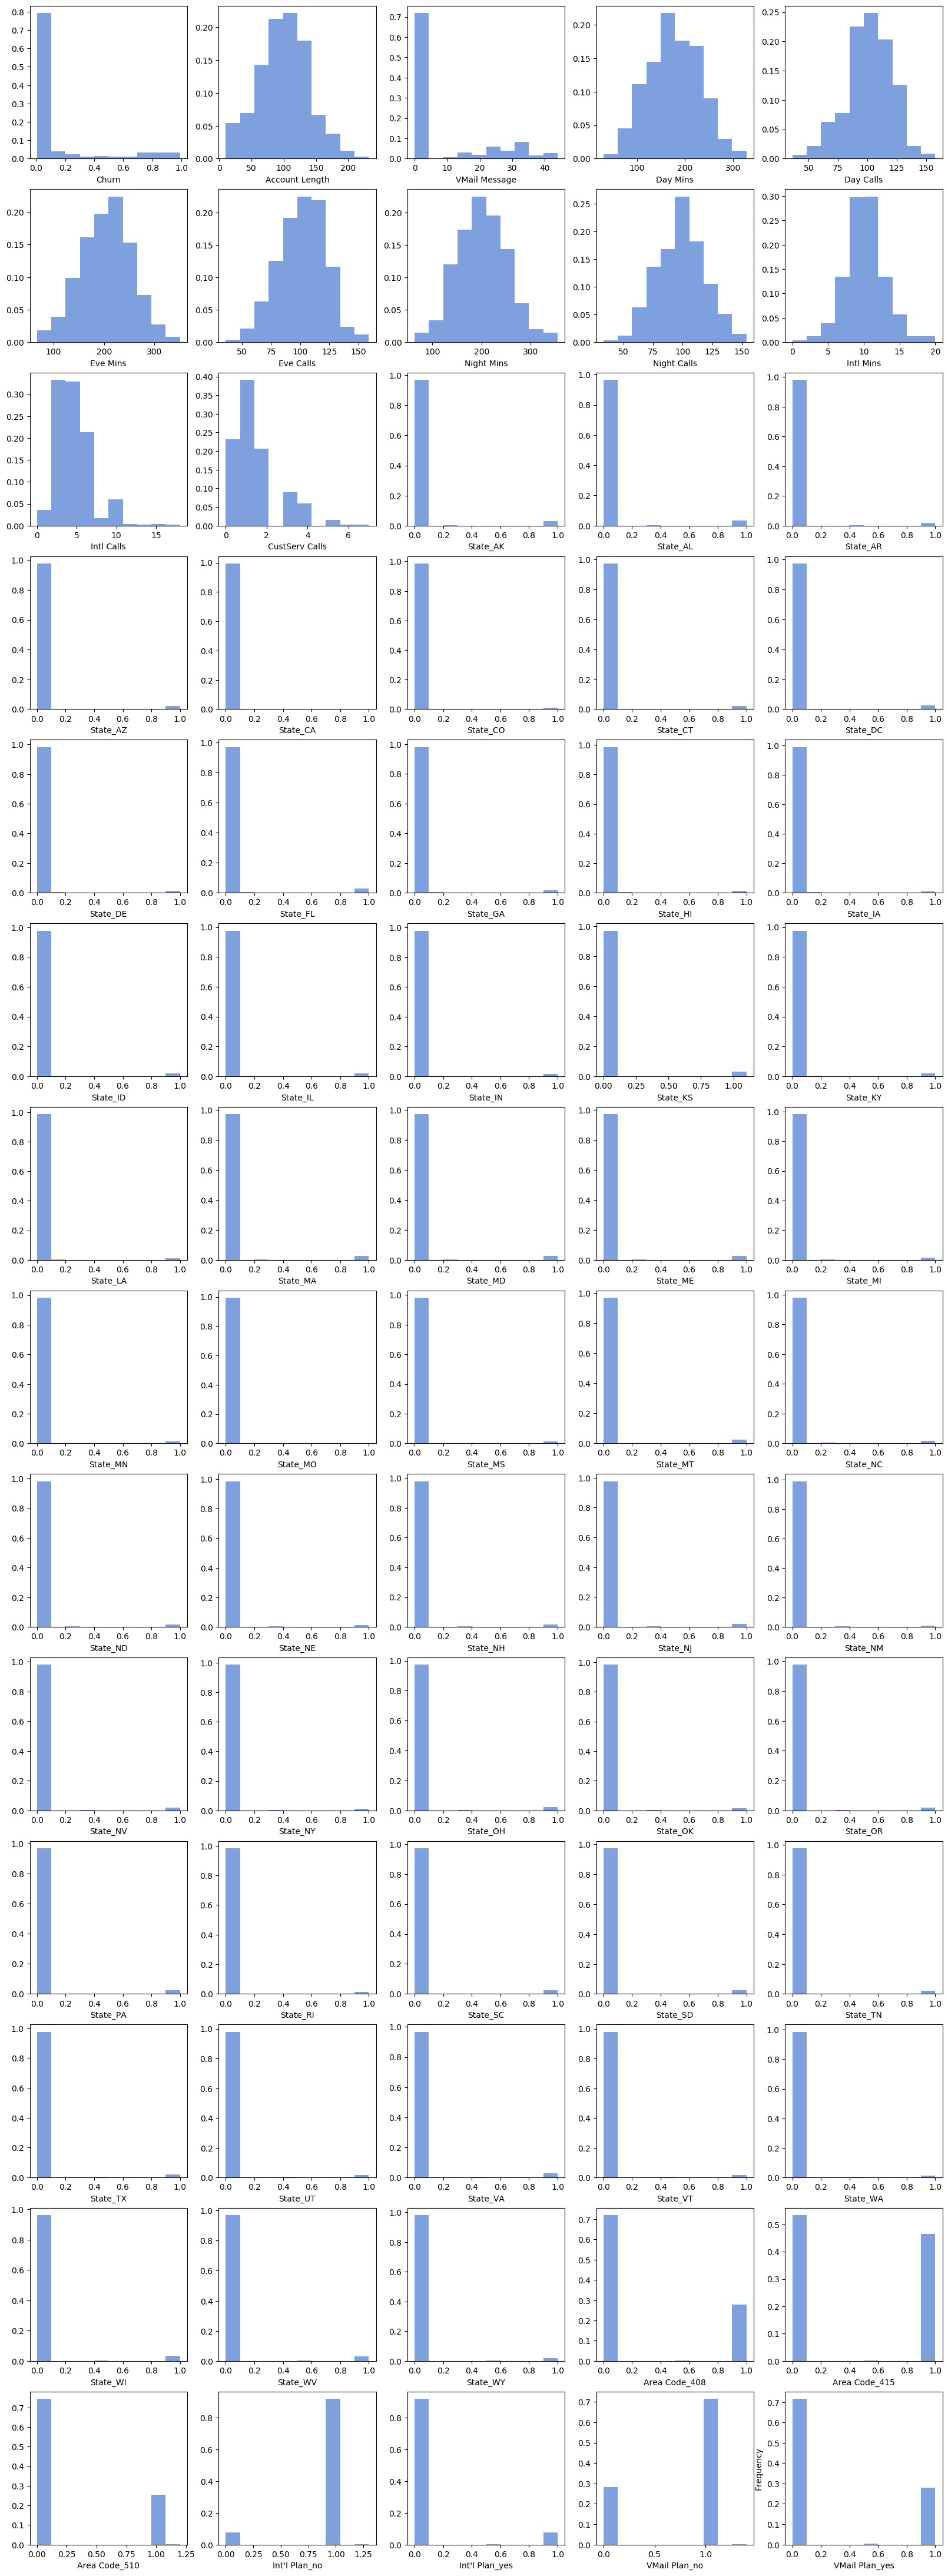

In [27]:
mu.show_distributions(features)

### Execution Stats vs Baseline

,num_present,num_missing,mean,sum,std_dev,min,max
Churn,7061,0,0.139527,9.851999e+02,0.262658,0.006144,0.989564
Account Length,7061,0,100.031865,7.063250e+05,39.365672,10.000000,232.000000
VMail Message,7061,0,7.955828,5.617610e+04,13.414185,0.000000,44.000000
Day Mins,7061,0,177.474876,1.253150e+06,55.323514,29.900000,328.100000
Day Calls,7061,0,101.602606,7.174160e+05,19.300694,36.000000,158.000000
...,...,...,...,...,...,...,...
Area Code_510,7061,0,0.257216,1.816200e+03,0.437915,0.000000,1.200000
Int'l Plan_no,7061,0,0.923141,6.518300e+03,0.268536,0.000000,1.300000
Int'l Plan_yes,7061,0,0.079357,5.603400e+02,0.268925,0.000000,1.000000
VMail Plan_no,7061,0,0.719643,5.081400e+03,0.451024,0.000000,1.400000


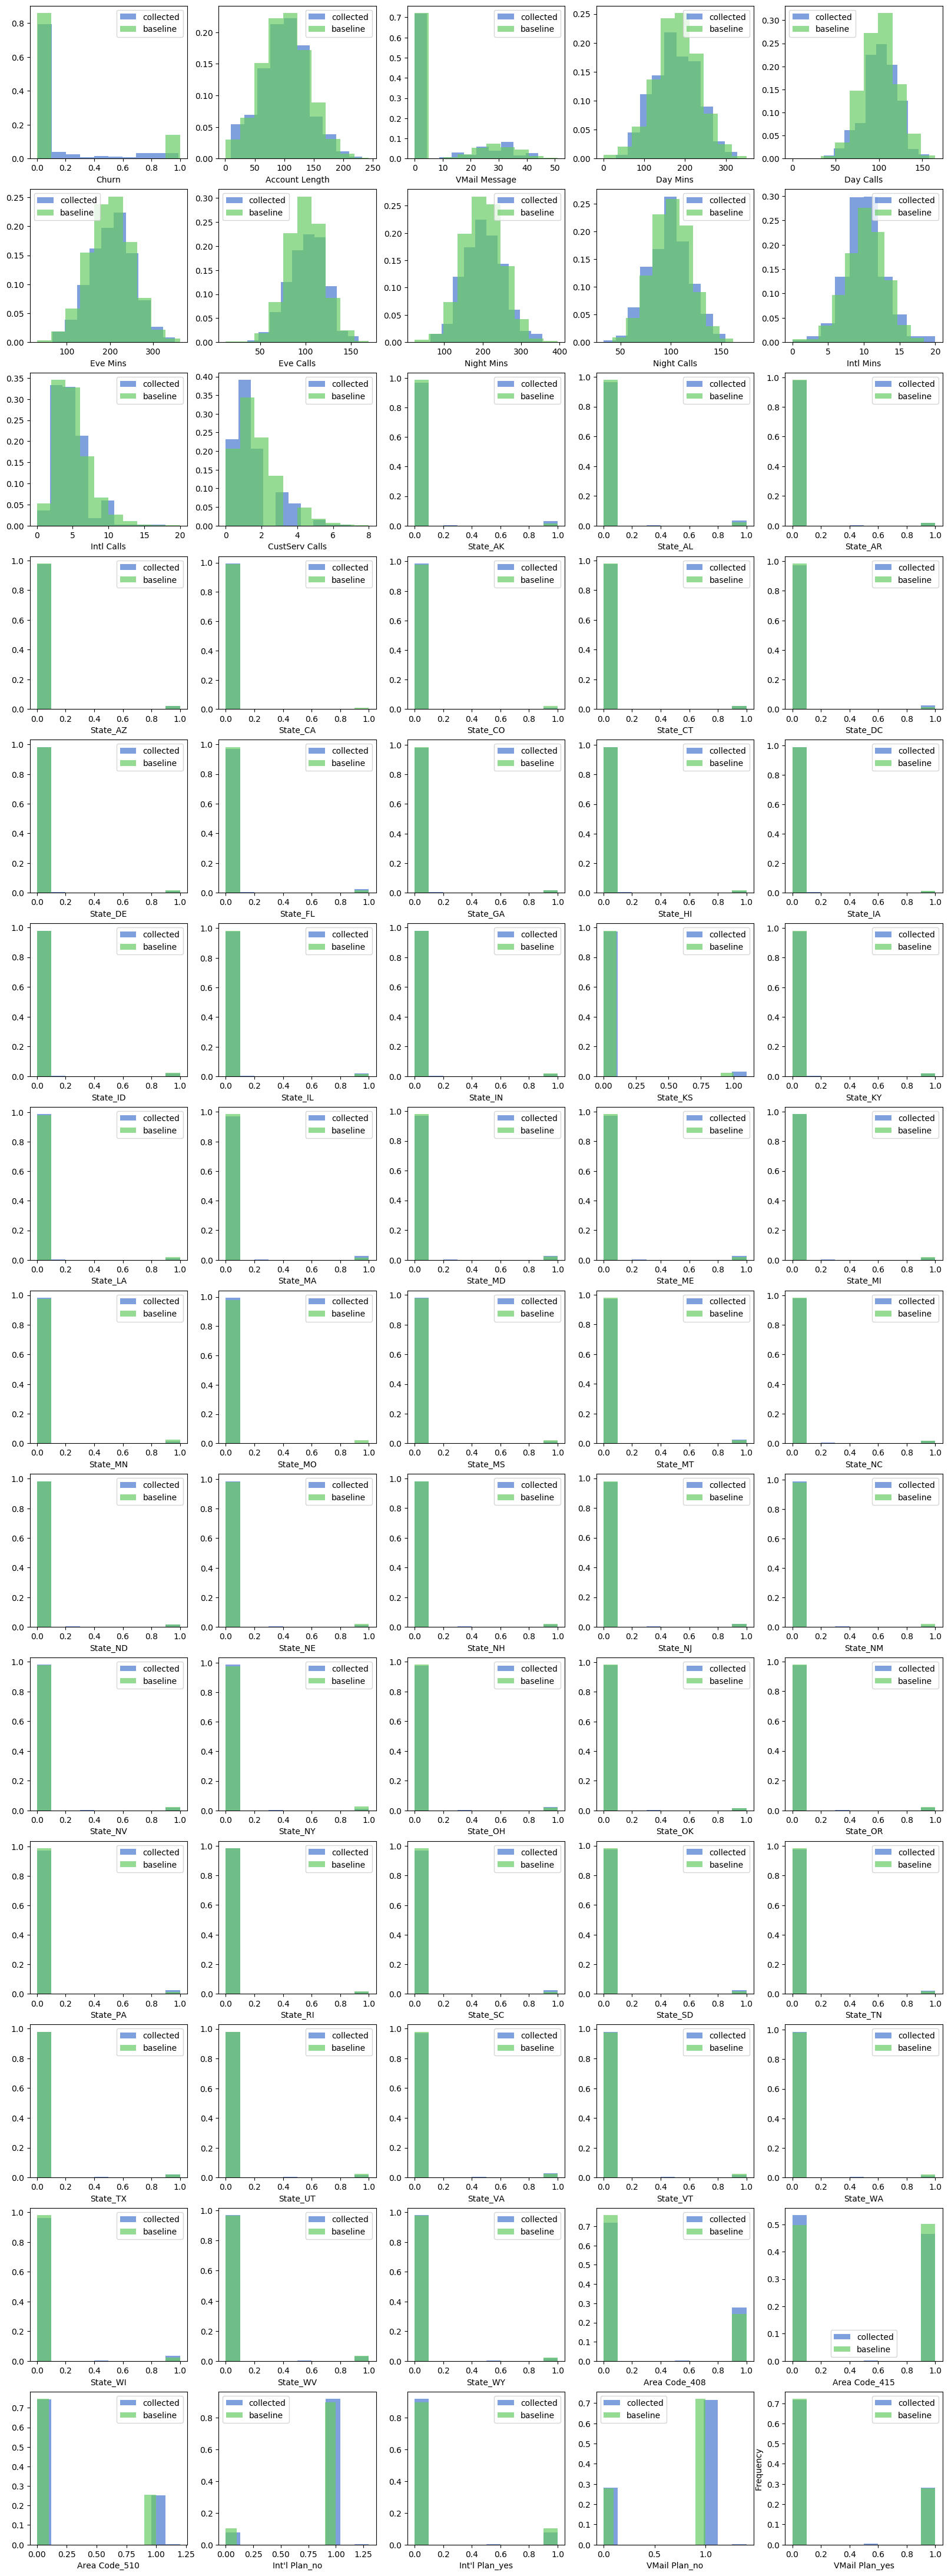

In [28]:
mu.show_distributions(features, feature_baselines)

## Cleanup scripts

You can keep your endpoint running to continue capturing data. If you do not plan to collect more data or use this endpoint further, delete the endpoint to avoid incurring additional charges. Note that deleting your endpoint does not delete the data that was captured during the model invocations. That data persists in Amazon S3 until you delete it yourself.

Please uncomment and run this cell to delete the schedule and the predictor.

In [29]:
# my_default_monitor.stop_monitoring_schedule()
# my_default_monitor.delete_monitoring_schedule()
# time.sleep(60)  # Wait for the deletion
# predictor.delete_model()
# predictor.delete_endpoint()